In [1]:
import json
import essentia
import essentia.standard as es
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import collections 
from sklearn.neighbors import NearestNeighbors
import pickle
import math
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import classification_report
import random

In [2]:
with open('../data/pickles/main_dict.pickle', 'rb') as f:
    main_dict = pickle.load(f)

In [225]:
df = pd.read_csv('../data/csv/track_vectors_bow.csv', index_col=0)
# df = df.drop(df.columns[70:], axis=1)
df

,file,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,...,hpcp.min,hpcp.std,average_loudness,dynamic_complexity,beats_count,bpm,onset_rate,danceability,chords_changes,chords_number
0,108885_7,-828.793396,323.996399,-22.645792,-5.707085,35.534069,-14.166079,-4.683322,6.431343,-6.317684,...,10.251307,8.973622,0.987681,1.411632,8,126.048035,1.493633,1.505061,0.000000,0.011364
1,095309_4,-637.838928,166.446960,-6.136036,46.390823,19.505096,18.494143,-9.090044,-2.106342,-2.007554,...,6.117591,9.206244,0.990443,1.113665,6,103.392471,3.236204,1.380159,0.000000,0.011364
2,015541_5,-727.724121,172.740601,1.624757,42.806423,-4.108257,7.864232,-5.218000,4.374446,3.596553,...,4.976926,6.756355,0.948790,4.572462,6,100.163498,5.725592,0.848880,0.034091,0.045455
3,046732_3,-717.759949,211.155151,17.932318,17.277416,17.350409,9.711357,17.276979,9.395988,9.956752,...,5.891515,8.553103,0.987175,1.664768,6,107.116699,4.231959,1.172508,0.068182,0.034091
4,080518_6,-584.165833,114.918137,17.930492,40.438145,12.670935,-2.737741,0.588371,-3.887019,6.478685,...,4.295446,4.414187,0.986588,1.031420,10,161.499023,2.987265,1.615097,0.045455,0.045455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63896,141561_4,-659.372375,117.638840,27.754400,34.788445,18.494167,-6.088364,-3.254398,-2.114888,-0.149268,...,2.722545,5.040314,0.959980,2.191639,4,74.898102,2.489388,0.831519,0.090909,0.068182
63897,043844_2,-645.126587,122.071121,13.026981,20.820780,12.430963,3.860647,6.052197,7.274552,7.558539,...,5.027837,3.313581,0.987013,4.353818,6,93.139641,4.480898,1.284844,0.125000,0.079545
63898,111871_3,-622.005859,179.936157,-25.739531,35.570972,-10.440171,24.467636,-16.438679,9.052222,-1.446382,...,3.476727,4.556766,0.987925,0.759895,6,94.659096,0.248939,1.401329,0.045455,0.045455
63899,000212_8,-704.640320,158.871490,-3.703846,7.979444,-8.273800,-15.582794,-0.888886,3.670900,-10.424666,...,4.848818,6.085067,0.990684,3.771466,5,172.265625,5.007722,0.971306,0.000000,0.022727


In [226]:
df_train = pd.read_csv('../data/csv/train_2.csv', index_col=0)
df_train

,file,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,...,pitch_salience.min.8,pitch_salience.std.8,chords.max.8,chords.mean.8,chords.min.8,chords.std.8,hpcp.max.8,hpcp.mean.8,hpcp.min.8,hpcp.std.8
0,113360.mp3,-862.656494,206.789871,50.152176,25.817299,16.106518,-1.038179,-14.124306,0.469769,-18.041723,...,0.104731,0.131907,0.839291,0.532144,0.258613,0.124811,35.831059,14.959072,3.070178,7.288480
1,113564.mp3,-645.366455,138.021118,13.892608,22.599394,18.474199,3.581496,-4.732511,-14.586736,-8.281308,...,0.259244,0.097776,0.691749,0.467287,0.207034,0.111577,35.785088,13.921927,2.618005,6.847598
2,113950.mp3,-794.236084,169.969589,26.764826,38.086010,10.864186,12.172462,-6.645301,-3.275297,-9.829071,...,0.112524,0.130163,0.770893,0.615786,0.365535,0.079525,35.804550,15.433070,2.676239,7.629828
3,113267.mp3,-639.567993,129.603104,-77.233673,1.809941,3.417638,-8.119690,-14.168982,9.181040,-12.034758,...,0.273620,0.119000,0.741139,0.547176,0.267749,0.099131,35.739342,10.841406,2.722672,5.521516
4,113261.mp3,-663.177551,117.829987,44.321461,32.515041,4.016469,9.938189,-4.446004,6.427977,-5.873170,...,0.136364,0.138839,0.663160,0.460699,0.237102,0.089502,35.844589,11.433019,3.062327,5.329480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7981,029040.mp3,-688.951660,110.380043,-1.830580,41.865685,12.073243,27.379248,25.519491,18.643660,2.040310,...,0.037965,0.156953,0.627632,0.452549,0.259658,0.089888,35.813511,13.423307,3.492393,6.177996
7982,029255.mp3,-712.312744,168.428848,-79.193497,15.317687,-19.223267,-3.262109,-13.500081,-9.117866,0.947261,...,0.140011,0.139329,0.697704,0.469045,0.260135,0.084404,35.851913,16.614149,0.000000,10.594819
7983,029526.mp3,-781.963379,16.143452,-47.208302,-46.300362,-41.306210,-26.232506,-31.810162,-15.413300,6.781355,...,0.225821,0.115231,0.569408,0.446405,0.227650,0.060741,35.851040,20.483692,4.004978,8.654058
7984,029245.mp3,-628.765808,109.755341,11.579667,35.267372,0.912285,4.590338,4.857110,8.353178,12.665811,...,0.287203,0.092962,0.747907,0.542799,0.222208,0.104758,35.841602,13.581528,3.772308,6.252968


In [227]:
df_test = pd.read_csv('../data/csv/test_2.csv', index_col=0)
df_test

,file,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,...,pitch_salience.min.8,pitch_salience.std.8,chords.max.8,chords.mean.8,chords.min.8,chords.std.8,hpcp.max.8,hpcp.mean.8,hpcp.min.8,hpcp.std.8
31,113343.mp3,-768.410583,177.532913,-5.232254,-1.268531,-16.643265,-22.899082,-12.472708,-13.560805,-32.071739,...,0.067390,0.145798,0.754852,0.559476,0.225193,0.102047,35.872833,27.349634,7.658070,8.931489
117,099411.mp3,-614.496033,161.632812,-30.135782,20.613056,-3.866533,0.235105,-3.852171,5.199200,4.165448,...,0.322384,0.084757,0.763652,0.476928,0.216093,0.093903,34.102570,11.609141,3.171824,5.582154
150,099419.mp3,-600.287109,152.651749,-6.931434,16.835726,-7.863964,-0.967983,-11.526454,2.808550,3.023355,...,0.418272,0.073019,0.830834,0.591593,0.312676,0.130382,35.713341,10.028034,3.322457,5.291312
179,074421.mp3,-623.853394,122.672737,17.257471,4.505549,0.719744,-2.922961,-5.741470,-1.727011,-18.558123,...,0.247513,0.099405,0.629668,0.534170,0.403778,0.045467,35.743763,15.102151,4.752180,7.138603
290,144469.mp3,-723.618652,252.936325,-30.126852,29.864367,19.096693,-6.951768,-14.872321,-2.849590,0.601918,...,0.204854,0.104727,0.695542,0.541956,0.271407,0.079417,35.818981,15.647316,3.569310,7.347943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7747,001040.mp3,-563.456299,104.120575,-6.972217,39.065773,12.155280,29.084288,-4.599654,1.194338,-0.117812,...,0.198499,0.118034,0.692115,0.444388,0.283190,0.068971,35.147663,10.454682,2.464400,5.436674
7767,001686.mp3,-665.148071,110.822456,1.305718,19.301023,-8.485282,2.736990,-10.153784,-9.214011,-8.195502,...,0.105094,0.121080,0.801286,0.576270,0.340960,0.093195,35.845860,15.940372,3.966340,7.548143
7822,004079.mp3,-623.008057,93.500755,21.506807,34.539505,5.349083,1.526804,-4.189599,-1.122090,-7.840350,...,0.152666,0.095020,0.746929,0.545348,0.295329,0.100399,35.796947,12.347969,3.913325,5.723447
7842,004835.mp3,-631.604858,120.129745,-22.318903,19.311491,-9.074204,2.220330,-10.822631,-6.159751,1.399805,...,0.027199,0.168232,0.741165,0.527163,0.292858,0.104844,35.861649,11.543086,2.355000,6.220985


In [228]:
df['new'] = [x[:-2] for x in df.file.values]
df

,file,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,...,hpcp.std,average_loudness,dynamic_complexity,beats_count,bpm,onset_rate,danceability,chords_changes,chords_number,new
0,108885_7,-828.793396,323.996399,-22.645792,-5.707085,35.534069,-14.166079,-4.683322,6.431343,-6.317684,...,8.973622,0.987681,1.411632,8,126.048035,1.493633,1.505061,0.000000,0.011364,108885
1,095309_4,-637.838928,166.446960,-6.136036,46.390823,19.505096,18.494143,-9.090044,-2.106342,-2.007554,...,9.206244,0.990443,1.113665,6,103.392471,3.236204,1.380159,0.000000,0.011364,095309
2,015541_5,-727.724121,172.740601,1.624757,42.806423,-4.108257,7.864232,-5.218000,4.374446,3.596553,...,6.756355,0.948790,4.572462,6,100.163498,5.725592,0.848880,0.034091,0.045455,015541
3,046732_3,-717.759949,211.155151,17.932318,17.277416,17.350409,9.711357,17.276979,9.395988,9.956752,...,8.553103,0.987175,1.664768,6,107.116699,4.231959,1.172508,0.068182,0.034091,046732
4,080518_6,-584.165833,114.918137,17.930492,40.438145,12.670935,-2.737741,0.588371,-3.887019,6.478685,...,4.414187,0.986588,1.031420,10,161.499023,2.987265,1.615097,0.045455,0.045455,080518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63896,141561_4,-659.372375,117.638840,27.754400,34.788445,18.494167,-6.088364,-3.254398,-2.114888,-0.149268,...,5.040314,0.959980,2.191639,4,74.898102,2.489388,0.831519,0.090909,0.068182,141561
63897,043844_2,-645.126587,122.071121,13.026981,20.820780,12.430963,3.860647,6.052197,7.274552,7.558539,...,3.313581,0.987013,4.353818,6,93.139641,4.480898,1.284844,0.125000,0.079545,043844
63898,111871_3,-622.005859,179.936157,-25.739531,35.570972,-10.440171,24.467636,-16.438679,9.052222,-1.446382,...,4.556766,0.987925,0.759895,6,94.659096,0.248939,1.401329,0.045455,0.045455,111871
63899,000212_8,-704.640320,158.871490,-3.703846,7.979444,-8.273800,-15.582794,-0.888886,3.670900,-10.424666,...,6.085067,0.990684,3.771466,5,172.265625,5.007722,0.971306,0.000000,0.022727,000212


In [229]:
df_test['new'] = [x[:-4] for x in df_test.file.values]
df_test

,file,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,...,pitch_salience.std.8,chords.max.8,chords.mean.8,chords.min.8,chords.std.8,hpcp.max.8,hpcp.mean.8,hpcp.min.8,hpcp.std.8,new
31,113343.mp3,-768.410583,177.532913,-5.232254,-1.268531,-16.643265,-22.899082,-12.472708,-13.560805,-32.071739,...,0.145798,0.754852,0.559476,0.225193,0.102047,35.872833,27.349634,7.658070,8.931489,113343
117,099411.mp3,-614.496033,161.632812,-30.135782,20.613056,-3.866533,0.235105,-3.852171,5.199200,4.165448,...,0.084757,0.763652,0.476928,0.216093,0.093903,34.102570,11.609141,3.171824,5.582154,099411
150,099419.mp3,-600.287109,152.651749,-6.931434,16.835726,-7.863964,-0.967983,-11.526454,2.808550,3.023355,...,0.073019,0.830834,0.591593,0.312676,0.130382,35.713341,10.028034,3.322457,5.291312,099419
179,074421.mp3,-623.853394,122.672737,17.257471,4.505549,0.719744,-2.922961,-5.741470,-1.727011,-18.558123,...,0.099405,0.629668,0.534170,0.403778,0.045467,35.743763,15.102151,4.752180,7.138603,074421
290,144469.mp3,-723.618652,252.936325,-30.126852,29.864367,19.096693,-6.951768,-14.872321,-2.849590,0.601918,...,0.104727,0.695542,0.541956,0.271407,0.079417,35.818981,15.647316,3.569310,7.347943,144469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7747,001040.mp3,-563.456299,104.120575,-6.972217,39.065773,12.155280,29.084288,-4.599654,1.194338,-0.117812,...,0.118034,0.692115,0.444388,0.283190,0.068971,35.147663,10.454682,2.464400,5.436674,001040
7767,001686.mp3,-665.148071,110.822456,1.305718,19.301023,-8.485282,2.736990,-10.153784,-9.214011,-8.195502,...,0.121080,0.801286,0.576270,0.340960,0.093195,35.845860,15.940372,3.966340,7.548143,001686
7822,004079.mp3,-623.008057,93.500755,21.506807,34.539505,5.349083,1.526804,-4.189599,-1.122090,-7.840350,...,0.095020,0.746929,0.545348,0.295329,0.100399,35.796947,12.347969,3.913325,5.723447,004079
7842,004835.mp3,-631.604858,120.129745,-22.318903,19.311491,-9.074204,2.220330,-10.822631,-6.159751,1.399805,...,0.168232,0.741165,0.527163,0.292858,0.104844,35.861649,11.543086,2.355000,6.220985,004835


In [230]:
df_bow_test = df[df['new'].isin(df_test['new'])]

In [231]:
df_bow_test.drop(columns=['new'], inplace=True)
df_bow_test

/home/obi-1-konobe/projects/mag/dp/dp_project/venv/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,file,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,...,hpcp.min,hpcp.std,average_loudness,dynamic_complexity,beats_count,bpm,onset_rate,danceability,chords_changes,chords_number
35,062533_6,-671.198120,138.639709,22.230555,27.525738,-11.621864,1.630476,-2.902935,8.267635,-1.793859,...,5.071622,5.241772,0.985129,2.608836,11,178.205841,5.725592,2.967737,0.090909,0.056818
242,024901_5,-580.970642,135.949112,-1.761406,5.122108,0.197555,12.185050,7.752786,3.857244,3.814994,...,2.979335,4.687755,0.987935,1.094479,7,110.388374,0.248939,0.996418,0.227273,0.102273
551,010673_6,-600.906555,145.373917,11.210205,41.238419,1.708439,13.828434,-3.756881,2.842203,1.823862,...,4.325215,4.686678,0.990013,0.890320,7,118.819580,3.236204,2.404340,0.181818,0.068182
776,044799_6,-658.365112,81.723038,5.717978,40.544865,25.803167,10.782271,9.888111,20.238461,10.660755,...,4.164757,3.899349,0.989829,2.411690,10,165.964447,4.729836,2.056803,0.022727,0.034091
802,001040_6,-609.069214,87.350426,-6.621530,41.620632,-1.524995,25.443741,1.757494,-0.172147,-5.259410,...,4.040373,5.578956,0.989808,1.487276,7,123.570335,5.227714,6.020297,0.125000,0.045455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63713,033020_2,-600.168884,149.759384,-32.586529,26.033113,-20.352365,-1.755566,-6.348417,-6.095432,-12.657984,...,3.750897,7.128789,0.987302,0.821489,7,119.274834,3.485143,1.090376,0.022727,0.034091
63714,085027_1,-809.702759,259.068512,24.602499,14.581144,16.824120,12.827282,-15.624825,-3.438228,8.843854,...,7.147578,4.152464,0.985452,2.413377,7,117.453850,1.991510,1.341899,0.011364,0.022727
63782,004233_3,-794.266541,177.278717,17.014393,55.412407,0.514055,-1.309268,-13.654597,-18.980249,-3.876530,...,5.535080,7.754101,0.981403,5.057644,8,124.047264,3.983020,1.006845,0.125000,0.068182
63854,075752_5,-659.443115,141.896500,24.623154,33.494846,16.867090,-5.384980,5.480534,7.794600,5.321544,...,4.201403,7.531118,0.987617,1.625815,11,178.205811,5.725592,1.855603,0.068182,0.045455


In [232]:
df_bow_train = df.drop(df_bow_test.index)
df_bow_train.drop(columns=['new'], inplace=True)

In [233]:
X_train = df_bow_train.drop(columns=['file']).values
X_test = df_bow_test.drop(columns=['file']).values

In [234]:
print(X_train.shape, X_test.shape)

(63101, 77) (800, 77)


In [235]:
scaler = StandardScaler()

In [236]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [237]:
X_train = scaler.transform(X_train)


In [238]:
X_test = scaler.transform(X_test)

In [337]:
n_clusters = 80

In [338]:
kmeans = KMeans(n_clusters=n_clusters, n_jobs=-1, n_init=10)

In [339]:
kmeans.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=80, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [340]:
clusters = kmeans.predict(X_train)

In [341]:
kmeans.n_iter_

169

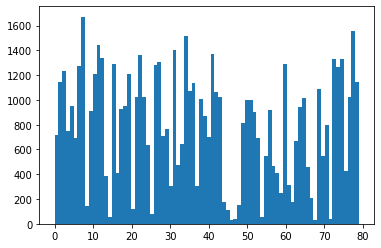

In [342]:
plt.hist(clusters, bins=n_clusters)
plt.show()

In [343]:
unique, counts = np.unique(clusters, return_counts=True)

In [344]:
a = np.asarray((unique, counts)).T
sorted(a, key=lambda x: x[1])

[array([68, 31]),
 array([46, 32]),
 array([72, 35]),
 array([47, 41]),
 array([14, 55]),
 array([54, 56]),
 array([25, 81]),
 array([ 45, 113]),
 array([ 20, 117]),
 array([  8, 140]),
 array([ 48, 153]),
 array([ 62, 174]),
 array([ 44, 176]),
 array([ 67, 209]),
 array([ 59, 246]),
 array([ 37, 302]),
 array([ 30, 304]),
 array([ 61, 314]),
 array([ 13, 385]),
 array([ 16, 408]),
 array([ 58, 411]),
 array([ 76, 426]),
 array([ 66, 461]),
 array([ 57, 467]),
 array([ 32, 474]),
 array([ 70, 545]),
 array([ 55, 548]),
 array([ 24, 637]),
 array([ 33, 644]),
 array([ 63, 672]),
 array([ 53, 689]),
 array([  5, 694]),
 array([ 40, 699]),
 array([ 28, 711]),
 array([  0, 717]),
 array([  3, 750]),
 array([ 29, 762]),
 array([ 71, 800]),
 array([ 49, 812]),
 array([ 39, 868]),
 array([ 52, 901]),
 array([  9, 909]),
 array([ 56, 917]),
 array([ 17, 923]),
 array([ 64, 941]),
 array([ 18, 952]),
 array([  4, 954]),
 array([ 50, 998]),
 array([ 51, 999]),
 array([  38, 1011]),
 array([  65

In [345]:
clusters_test = kmeans.predict(X_test)

In [346]:
df_bow_train['cluster'] = clusters
df_bow_test['cluster'] = clusters_test

/home/obi-1-konobe/projects/mag/dp/dp_project/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [347]:
df_bow_train

,file,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,...,hpcp.std,average_loudness,dynamic_complexity,beats_count,bpm,onset_rate,danceability,chords_changes,chords_number,cluster
0,108885_7,-828.793396,323.996399,-22.645792,-5.707085,35.534069,-14.166079,-4.683322,6.431343,-6.317684,...,8.973622,0.987681,1.411632,8,126.048035,1.493633,1.505061,0.000000,0.011364,5
1,095309_4,-637.838928,166.446960,-6.136036,46.390823,19.505096,18.494143,-9.090044,-2.106342,-2.007554,...,9.206244,0.990443,1.113665,6,103.392471,3.236204,1.380159,0.000000,0.011364,7
2,015541_5,-727.724121,172.740601,1.624757,42.806423,-4.108257,7.864232,-5.218000,4.374446,3.596553,...,6.756355,0.948790,4.572462,6,100.163498,5.725592,0.848880,0.034091,0.045455,69
3,046732_3,-717.759949,211.155151,17.932318,17.277416,17.350409,9.711357,17.276979,9.395988,9.956752,...,8.553103,0.987175,1.664768,6,107.116699,4.231959,1.172508,0.068182,0.034091,35
4,080518_6,-584.165833,114.918137,17.930492,40.438145,12.670935,-2.737741,0.588371,-3.887019,6.478685,...,4.414187,0.986588,1.031420,10,161.499023,2.987265,1.615097,0.045455,0.045455,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63896,141561_4,-659.372375,117.638840,27.754400,34.788445,18.494167,-6.088364,-3.254398,-2.114888,-0.149268,...,5.040314,0.959980,2.191639,4,74.898102,2.489388,0.831519,0.090909,0.068182,51
63897,043844_2,-645.126587,122.071121,13.026981,20.820780,12.430963,3.860647,6.052197,7.274552,7.558539,...,3.313581,0.987013,4.353818,6,93.139641,4.480898,1.284844,0.125000,0.079545,18
63898,111871_3,-622.005859,179.936157,-25.739531,35.570972,-10.440171,24.467636,-16.438679,9.052222,-1.446382,...,4.556766,0.987925,0.759895,6,94.659096,0.248939,1.401329,0.045455,0.045455,77
63899,000212_8,-704.640320,158.871490,-3.703846,7.979444,-8.273800,-15.582794,-0.888886,3.670900,-10.424666,...,6.085067,0.990684,3.771466,5,172.265625,5.007722,0.971306,0.000000,0.022727,78


In [348]:
train_mtx = np.zeros((df_train.shape[0], n_clusters))
test_mtx = np.zeros((df_test.shape[0], n_clusters))

In [349]:
for i in range(df_train.shape[0]):
    track = df_train.iloc[i].file
    for j in range(1, 9):
        row = df_bow_train[df_bow_train.file == f'{track[:-4]}_{j}']
        cluster = row.cluster.values
        train_mtx[i][cluster] += 1

In [350]:
for i in range(df_test.shape[0]):
    track = df_test.iloc[i].file
    for j in range(1, 9):
        row = df_bow_test[df_bow_test.file == f'{track[:-4]}_{j}']
        cluster = row.cluster.values
        test_mtx[i][cluster] += 1

In [351]:
train_mtx /= 8
test_mtx /= 8

In [352]:
def count_good_recommend(query_idx, answer_list, trhold):
    counter = 0
    query_id = int(df_test.iloc[query_idx].file[:-4])
    relevant = [query_id]
    query_tags = main_dict[query_id]['all_tags']
    for idx in answer_list:
        answer_id = int(df_train.iloc[idx].file[:-4])
        answer_tags = main_dict[answer_id]['all_tags']
        score = 0
        i = 0
        for tag in answer_tags:
            if tag in query_tags:
                i += 1
        if i == 0:
            continue
        
        precision = i / len(answer_tags)
        recall = i / len(query_tags)
        score = 2 * precision * recall / (precision + recall)
        if score >= trhold:        
            counter += 1
            relevant.append(answer_id)
    return counter, relevant

In [353]:
def count_ndcg(neighbors, relevant_list):
    dcg = 0
    idcg = 0
    for i in range(len(neighbors)):
        track = int(df_train.iloc[neighbors[i]].file[:-4])
        if track in relevant_list:
            dcg += 1 / math.log(i + 2, 2)
        idcg += 1 / math.log(i + 2, 2)
    ndcg = dcg / idcg
    return ndcg

In [354]:
for dist in ['euclidean', 'manhattan']:
    neigh = NearestNeighbors(10, metric=dist)
    neigh.fit(train_mtx)
    mean_ap = 0
    ndcg = 0
    for i in range(100):
        neighbors = neigh.kneighbors([test_mtx[i]])[1][0]
        relevant_num, relevant_list = count_good_recommend(i, neighbors, trhold=0.4)
    #     print(relevant_list)
    #     print(relevant_list[0], [df_train.iloc[x].file[:-4] for x in neighbors])
        p_at_10 = relevant_num / 10
        mean_ap += p_at_10
        ndcg += count_ndcg(neighbors, relevant_list[1:])
    mean_ap /= 100 
    mean_ndcg = ndcg / 100
    print(neigh.metric, mean_ap, mean_ndcg)

euclidean 0.039000000000000014 0.036679963012850696
manhattan 0.031000000000000007 0.02897556607145765


In [355]:
cos_similarity_mtx = cosine_similarity(test_mtx, train_mtx)

In [356]:
mean_ap = 0
ndcg = 0
for i in range(100):
    arr = cos_similarity_mtx[i]
    neighbors = arr.argsort()[-10:][::-1]
    relevant_num, relevant_list = count_good_recommend(i, neighbors, trhold=0.4)
#     print(relevant_list)
#     print(relevant_list[0], [df_train.iloc[x].track[:-4] for x in neighbors])
    p_at_10 = relevant_num / 10
    mean_ap += p_at_10
    ndcg += count_ndcg(neighbors, relevant_list[1:])
mean_ap /= 100 
mean_ndcg = ndcg / 100

In [357]:
mean_ap

0.036000000000000004

In [358]:
mean_ndcg

0.03590591711643441

In [51]:
with open('../data/tags_similarity.txt', 'r') as f:
    data = f.readlines()
all_similarity = [x.strip('\n').split() for x in data]

In [52]:
df_train_2 = df_train.reset_index(drop=True)

In [95]:
features = list()
target = list()
for tupple in all_similarity:
    try:
        idx_1 = df_train_2[df_train_2.file == tupple[0]].index[0]
    except:
        pass
    idx_2 = df_train_2[df_train_2.file == tupple[1]].index[0]
    arr_1 = train_mtx[idx_1]
    arr_2 = train_mtx[idx_2]
    combo = np.hstack((arr_1, arr_2))
    features.append(combo)
    target.append(float(tupple[2]))

In [96]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.1, 
    random_state=123
)

In [97]:
lgbm = LGBMRegressor(num_iteration=10000, max_depth=8, reg_lambda=0.8, reg_alpha=0.6)
lgbm.fit(features_train, target_train)
y_pred_train = lgbm.predict(features_train)
y_pred_test = lgbm.predict(features_test)
rmse_train = mean_squared_error(target_train, y_pred_train)
rmse_test = mean_squared_error(target_test, y_pred_test)
r2_train = r2_score(target_train, y_pred_train)
r2_test = r2_score(target_test, y_pred_test)
print(f'rmse {rmse_train}/{rmse_test} r2 {r2_train}/{r2_test}')

/home/obi-1-konobe/projects/mag/dp/dp_project/venv/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse 0.023879991865568308/0.07738328427195645 r2 0.7785357187924735/0.2795796169898347


In [99]:
model.fit(features_train, target_train)
target_pred = model.predict(features_test)
target_train_pred = model.predict(features_train)

ValueError: Unknown label type: 'continuous'

In [100]:
neigh = NearestNeighbors(100, metric='manhattan')
neigh.fit(train_mtx)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='manhattan',
                 metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                 radius=1.0)

In [101]:
def rank_by_model(model, neighb, arr_test):
    result = list()
    for idx in neighb:
        arr_2 = train_mtx[idx]
        combo = np.hstack((arr_test, arr_2))
        score = model.predict([combo])
#         score = model.predict_proba([combo])[:,1]
        result.append((idx, score))
    top_10 = sorted(result, key=lambda x: x[1], reverse=True)[:10]
    top_10 = [x[0] for x in top_10]

    return top_10

In [102]:
mean_ap = 0
ndcg = 0
for i in range(100):
    neighbors = neigh.kneighbors([test_mtx[i]])[1][0]
    level_2 = rank_by_model(model, neighbors, test_mtx[i])
    relevant_num, relevant_list = count_good_recommend(i, level_2, trhold=0.3)
#     print(relevant_list)
    print(relevant_list[0], [df_train.iloc[x].track[:-4] for x in level_2])
    p_at_10 = relevant_num / 10
    mean_ap += p_at_10
    ndcg += count_ndcg(level_2, relevant_list[1:])
mean_ap /= 100 
mean_ndcg = ndcg / 100

ValueError: Number of features of the model must match the input. Model n_features_ is 154 and input n_features is 150 

In [154]:
mean_ap

0.08499999999999995

In [155]:
mean_ndcg

0.08784929093048315

In [156]:
cos_similarity_mtx = cosine_similarity(test_mtx, train_mtx)

In [157]:
mean_ap = 0
ndcg = 0
for i in range(100):
    arr = cos_similarity_mtx[i]
    neighbors = arr.argsort()[-100:][::-1]
    level_2 = rank_by_model(model, neighbors, test_mtx[i])
    relevant_num, relevant_list = count_good_recommend(i, level_2, trhold=0.3)
#     relevant_num, relevant_list = count_good_recommend(i, neighbors, trhold=0.4)
#     print(relevant_list)
    print(relevant_list[0], [df_train.iloc[x].track[:-4] for x in level_2])
    p_at_10 = relevant_num / 10
    mean_ap += p_at_10
    ndcg += count_ndcg(neighbors, relevant_list[1:])
mean_ap /= 100 
mean_ndcg = ndcg / 100

10673 ['069209', '047195', '076121', '110983', '125004', '080402', '012737', '038904', '063117', '085816']
66643 ['004094', '023862', '126426', '064864', '129926', '009513', '121415', '126584', '137990', '056651']
194 ['060857', '010682', '078213', '091793', '072612', '044778', '083911', '090529', '016744', '043588']
74421 ['081491', '125183', '132561', '052120', '043865', '114401', '126429', '103520', '146988', '001682']
131553 ['144467', '071507', '112020', '105408', '052042', '053862', '099096', '058215', '123438', '122805']
24431 ['142666', '081555', '129040', '127660', '114538', '116099', '115892', '123974', '072074', '114236']
144469 ['064861', '067011', '126455', '003912', '121654', '088874', '040243', '126550', '121256', '134979']
87100 ['081814', '012067', '108018', '108026', '129042', '131917', '087107', '144476', '124177', '108025']
69204 ['069196', '051158', '148075', '098585', '123973', '118500', '094468', '123937', '055242', '140925']
27454 ['087188', '003762', '066689', 

1686 ['124425', '099364', '134388', '038817', '138318', '004232', '059688', '073675', '060871', '060864']
73365 ['134446', '027802', '004521', '115698', '098077', '043621', '119592', '112483', '120319', '053723']
5264 ['149626', '047070', '130921', '097586', '114401', '103520', '126429', '001682', '141181', '000212']
19759 ['074371', '023862', '042247', '126584', '129926', '121415', '045474', '069787', '113276', '056651']
41568 ['125620', '020366', '096695', '049394', '115892', '072781', '140421', '148124', '122936', '114072']
24429 ['134455', '134446', '079990', '138211', '133443', '124411', '082932', '075442', '019423', '141877']
86788 ['088854', '013325', '037730', '050752', '112526', '114198', '083790', '126186', '108503', '087151']
152418 ['134388', '038817', '059688', '060871', '073675', '134631', '003895', '098339', '080772', '060865']
64630 ['064604', '023353', '110779', '123977', '123968', '142086', '026008', '097814', '085040', '113453']
85832 ['087188', '003762', '066689', '

In [158]:
mean_ap

0.08099999999999997

In [159]:
mean_ndcg

0.008042961022334174

In [61]:
with_similar = list()
for idx in main_dict:
    if len(main_dict[idx]['similar_list']) > 0:
        with_similar.append(idx)

In [62]:
features = list()
target = list()
for idx in with_similar:
    track_1 = "{:06d}".format(idx) + '.mp3'
    if track_1 in df_train_2.file.values:
        id_1 = df_train_2[df_train_2.file == track_1].index[0]
        arr_1 = X_train[id_1]
        for pair in main_dict[idx]['similar_list']:
            artist, title, _ = pair
            for idx_2 in main_dict:
                if main_dict[idx_2]['artist_name'] == artist and main_dict[idx_2]['track_title'] == title:
                    track_2 = "{:06d}".format(idx_2) + '.mp3'
                    if track_2 in df_train_2.file.values:
                        id_2 = df_train_2[df_train_2.file == track_2].index[0]
                        arr_2 = X_train[id_2]
                        combo = np.hstack((arr_1, arr_2))
                        features.append(combo)
                        target.append(1)
                        break

In [63]:
len(target)

1898

In [64]:
while len(features) < 1898 * 2:
    pair = random.sample(list(df_train_2.file.values), 2)
    id_1 = int(pair[0][:-4])
    id_2 = int(pair[1][:-4])
    if len(set(main_dict[id_1]['all_genres']) & set(main_dict[id_2]['all_genres'])) == 0:
        idx_1 = df_train_2[df_train_2.file == pair[0]].index[0]
        idx_2 = df_train_2[df_train_2.file == pair[1]].index[0]
        arr_1 = X_train[idx_1]
        arr_2 = X_train[idx_2]
        combo = np.hstack((arr_1, arr_2))
        features.append(combo)
        target.append(0) 

In [65]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.1, 
    random_state=123
)

In [84]:
model = LGBMClassifier(num_iteration=10000, max_depth=7, reg_lambda=0.8, reg_alpha=0.6)

In [85]:
model.fit(features_train, target_train)
target_pred = model.predict(features_test)
target_train_pred = model.predict(features_train)

/home/obi-1-konobe/projects/mag/dp/dp_project/venv/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [86]:
print(classification_report(target_test, target_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       197
           1       0.76      0.76      0.76       183

    accuracy                           0.77       380
   macro avg       0.77      0.77      0.77       380
weighted avg       0.77      0.77      0.77       380



In [87]:
neigh = NearestNeighbors(100, metric='manhattan')
neigh.fit(train_mtx)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='manhattan',
                 metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                 radius=1.0)

In [88]:
def rank_by_model(model, neighb, arr_test):
    result = list()
    for idx in neighb:
        arr_2 = train_mtx[idx]
        combo = np.hstack((arr_test, arr_2))
#         score = model.predict([combo])
        score = model.predict_proba([combo])[:,1]
        result.append((idx, score))
    top_10 = sorted(result, key=lambda x: x[1], reverse=True)[:10]
    top_10 = [x[0] for x in top_10]

    return top_10

In [89]:
mean_ap = 0
ndcg = 0
for i in range(100):
    neighbors = neigh.kneighbors([test_mtx[i]])[1][0]
    level_2 = rank_by_model(model, neighbors, test_mtx[i])
    relevant_num, relevant_list = count_good_recommend(i, level_2, trhold=0.3)
#     print(relevant_list)
#     print(relevant_list[0], [df_train.iloc[x].track[:-4] for x in level_2])
    p_at_10 = relevant_num / 10
    mean_ap += p_at_10
    ndcg += count_ndcg(level_2, relevant_list[1:])
mean_ap /= 100 
mean_ndcg = ndcg / 100

ValueError: Number of features of the model must match the input. Model n_features_ is 154 and input n_features is 150 

In [172]:
mean_ap

0.08199999999999996

In [173]:
mean_ndcg

0.08298035836480601

In [174]:
cos_similarity_mtx = cosine_similarity(test_mtx, train_mtx)

In [175]:
mean_ap = 0
ndcg = 0
for i in range(100):
    arr = cos_similarity_mtx[i]
    neighbors = arr.argsort()[-100:][::-1]
    level_2 = rank_by_model(model, neighbors, test_mtx[i])
    relevant_num, relevant_list = count_good_recommend(i, level_2, trhold=0.3)
#     relevant_num, relevant_list = count_good_recommend(i, neighbors, trhold=0.4)
#     print(relevant_list)
    print(relevant_list[0], [df_train.iloc[x].track[:-4] for x in level_2])
    p_at_10 = relevant_num / 10
    mean_ap += p_at_10
    ndcg += count_ndcg(neighbors, relevant_list[1:])
mean_ap /= 100 
mean_ndcg = ndcg / 100

10673 ['111378', '122261', '102195', '145020', '106956', '084486', '117057', '028477', '134951', '084152']
66643 ['004520', '051918', '138071', '033072', '071304', '023862', '004094', '047201', '075194', '038781']
194 ['036999', '073658', '111186', '018038', '129922', '043590', '039666', '000540', '072562', '000546']
74421 ['085490', '130921', '144550', '017500', '121257', '052036', '129396', '097586', '148131', '135342']
131553 ['009559', '063226', '120513', '144467', '120194', '098622', '042475', '093944', '113261', '122648']
24431 ['016155', '033477', '115474', '122534', '118062', '115471', '027667', '129879', '108421', '051114']
144469 ['040238', '121256', '126885', '063208', '126587', '075432', '026754', '069188', '003911', '133833']
87100 ['043022', '001702', '149714', '054061', '000213', '120774', '047073', '010458', '027981', '116454']
69204 ['038365', '052631', '096657', '070654', '011766', '055232', '075378', '108524', '145752', '145755']
27454 ['085836', '014735', '128477', 

73365 ['053675', '004521', '140584', '108837', '009491', '078849', '089817', '107534', '104625', '082231']
5264 ['053229', '027164', '087194', '092125', '047071', '142550', '110107', '067237', '148131', '004071']
19759 ['004520', '103521', '129374', '051918', '138071', '146969', '150266', '047201', '062196', '115391']
41568 ['120105', '081543', '085485', '028266', '121739', '148124', '113022', '054235', '055286', '096694']
24429 ['014737', '131941', '138211', '127180', '113810', '098235', '120308', '133942', '067760', '114545']
86788 ['096402', '054624', '087151', '083790', '011933', '013325', '135373', '124477', '147412', '037730']
152418 ['153452', '043585', '093986', '106951', '014590', '020374', '124481', '057892', '115700', '126221']
64630 ['146879', '064364', '051261', '085839', '085594', '052644', '022091', '144423', '040845', '060472']
85832 ['014735', '040123', '128477', '085836', '044801', '086576', '140924', '097960', '111372', '111221']
75317 ['075419', '007489', '149951', 

In [176]:
mean_ap

0.07999999999999999

In [177]:
mean_ndcg

0.007925704856328796

In [17]:
features['lowlevel.mfcc.mean']

array([-8.2916156e+02,  1.9317177e+02,  4.2347931e+01,  5.4060452e+01,
       -2.3631012e+01, -1.9399572e+01,  6.8418140e+00, -1.7468027e+01,
       -1.2536197e+01, -5.9524351e-01, -4.3472978e-01,  1.5609742e+00,
       -6.0589099e+00], dtype=float32)

In [21]:
with open('../data/essentia/000534.json', 'r') as f:
    data = json.load(f)
data

{'metadata': {'version': {'essentia': '2.1-beta6-dev',
   'essentia_git_sha': 'v2.1_beta5-184-g344028cb',
   'extractor': 'music 2.0'},
  'audio_properties': {'analysis': {'equal_loudness': 0,
    'length': 29.9765758514,
    'sample_rate': 44100,
    'start_time': 0,
    'downmix': 'mix'},
   'bit_rate': 128000,
   'length': 29.9765758514,
   'lossless': 0,
   'number_channels': 2,
   'replay_gain': -9.71918869019,
   'sample_rate': 44100,
   'codec': 'mp3',
   'md5_encoded': '336cc18d14d663745b81b90bdfef8768'},
  'tags': {'file_name': '000534.mp3',
   'album': ['One Mind'],
   'artist': ['Charles Manson'],
   'date': ['2005'],
   'encodedby': ['iTunes v7.6.1.9'],
   'encoding': ['Lavf57.63.100'],
   'genre': ['Folk'],
   'title': ['I Can See You'],
   'tracknumber': ['1']}},
 'lowlevel': {'average_loudness': 0.513585805893,
  'barkbands_crest': {'max': 25.9294929504,
   'mean': 13.0073032379,
   'min': 4.34986209869,
   'stdev': 4.90071344376},
  'barkbands_flatness_db': {'max': 0.46

In [23]:
list(range(1, 31))

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]